In [7]:
# Class which provides custom metrics for accurency
class CustomAccurencyMetrics():
    # constructor
    def __init__(self):
        return

    # Method which provides counting accurancy (likehood) of two images
    def CountAccuracy(self, pred_image, true_image, eps = 0.001, shape=(36, 36)):
        accuracy = 0
        total_pxls = shape[0] * shape[1]

        for x in range(shape[0]):
            for y in range(shape[1]):
                accuracy = accuracy + (abs(pred_image[0][0][x][y] - true_image[0][0][x][y]) < eps)
        
        return float(accuracy / total_pxls) * 100


In [8]:
from PIL import Image
import numpy as np
import torch

from math import sqrt
from random import randint

# Class which provides generating syntetic data for "Blur" CNN
# Output: array of pairs: (1x1x36x36, 1x1x36x36) = [focused_image, blured_image]
class BlurDataGenerator:
    # constructor
    def __init__(self):
        return

    def CircleGenerator(self, shape=(36, 36), centerPadding = (0, 0), pixelRadius = 6, intensity = 100):
        circle = np.zeros(shape)
        centerCoords = [shape[0] / 2 - centerPadding[0], shape[1] / 2 - centerPadding[1]]

        for x in range(len(circle)):
            for y in range(len(circle[0])):
                if (x - centerCoords[0]) ** 2 + (y - centerCoords[1]) ** 2 <= pixelRadius * pixelRadius:
                    circle[x][y] = (128 + intensity * (pixelRadius * pixelRadius - ((x - centerCoords[0]) ** 2 + (y - centerCoords[1]) ** 2)) / (pixelRadius * pixelRadius))
        return circle

    def EmulatePSF(self, rad = 9., shape=(31, 31)):
        emulatedPSF = np.zeros(shape)

        centerX, centerY = int(shape[0] / 2), int(shape[1] / 2)

        # make unfocused circle
        for row in range(shape[0]):
            for col in range(shape[1]):
                if (row - centerX) ** 2 + (col - centerY) ** 2 <= rad * rad:
                    emulatedPSF[row][col] = 255 * (((rad * rad - ((row - centerX) ** 2 + (col - centerY) ** 2)) / (rad * rad)) ** 5)

        # make some shifts in rows
        for row in range(shape[0]):
            shiftsCnt = int(sqrt(abs(row - centerX)))
            for pxl in range(shape[1]):
                if (pxl + shiftsCnt) < shape[1]:
                    emulatedPSF[row][pxl] = emulatedPSF[row][pxl + shiftsCnt]
                else:
                    emulatedPSF[row][pxl] = 0

        # count psf pxls sum
        normalConst = 0
        for x in range(shape[0]):
            for y in range(shape[1]):
                normalConst = normalConst + emulatedPSF[x][y]

        # and normalize
        return emulatedPSF / normalConst

    def CountBluredPoint(self, bluredImage, circle, psf, row, col, border = 255):
        psfTmp = psf * circle[row][col]

        bI_shiftedRow = row - int(psf.shape[0] / 2)
        bI_shiftedCol = col - int(psf.shape[0] / 2)

        for row_psf in range(psfTmp.shape[0]):
            if bI_shiftedRow + row_psf >= 0 and bI_shiftedRow + row_psf < circle.shape[0]:
                for col_psf in range(psfTmp.shape[1]):
                    if bI_shiftedCol + col_psf >= 0 and bI_shiftedCol + col_psf < circle.shape[1]:
                        bluredImage[bI_shiftedRow + row_psf][bI_shiftedCol + col_psf] = bluredImage[bI_shiftedRow + row_psf][bI_shiftedCol + col_psf] + psfTmp[row_psf][col_psf]
                        if bluredImage[bI_shiftedRow + row_psf][bI_shiftedCol + col_psf] >= border:
                            bluredImage[bI_shiftedRow + row_psf][bI_shiftedCol + col_psf] = border

        return bluredImage

    def ImageConvolution2D(self, circle, psf):
        bluredImage = np.zeros(circle.shape, dtype=float)

        for row in range(len(circle)):
            for col in range(len(circle[0])):
                if (circle[row][col] != 0):
                    bluredImage = self.CountBluredPoint(bluredImage, circle, psf, row, col)
        return bluredImage

    def DataSetGenerator(self, dataSetPower = 100, batch_size = 10, rad_range=(12, 13), intensity_range=(64, 128), padding_range=(-5, 5)):
        dataSet = list()
        psf = self.EmulatePSF(shape=(35, 35))

        batches_cnt = int(dataSetPower / batch_size)

        for i in range(batches_cnt):
            newBatchCircles = list()
            newBatchBlured = list()
            print("Batch[{}/{}]".format(i+1, batches_cnt))

            for j in range(batch_size):
                centerPaddingX = randint(padding_range[0], padding_range[1])
                centerPaddingY = randint(padding_range[0], padding_range[1])
                intensity = randint(intensity_range[0], intensity_range[1])
                radius = randint(rad_range[0], rad_range[1])

                circle = self.CircleGenerator(centerPadding=(centerPaddingX, centerPaddingY), intensity=intensity, pixelRadius=radius)
                bluredCircle = self.ImageConvolution2D(circle, psf)

                dataSet.append((torch.from_numpy(np.array(circle).reshape(1, 1, 36, 36) / 255).float(), torch.from_numpy(np.array(bluredCircle).reshape(1, 1, 36, 36) / 255).float()))

        return np.array(dataSet)

    def GenerateOnePixelImage(self, shape = (36, 36)):
        centerX = int(shape[0] / 2)
        centerY = int(shape[1] / 2)

        one_pxl_img = np.zeros(shape)
        one_pxl_img[centerX][centerY] = 255
        return one_pxl_img

    def ImageTiffSaver(self, imageToSave, fileName, multiplyer = 1.):
        im = Image.fromarray(imageToSave * multiplyer)
        im.save(fileName)
        return

    def SavePSFTensor(self, psf, filename, rows = 31, cols = 31):
        psf_nparray = psf.detach().numpy()
        psf_nparray = psf_nparray.reshape(rows, cols)

        maxValue = 0
        for x in range(rows):
            for y in range(cols):
                if (psf_nparray[x][y] > maxValue):
                    maxValue = psf_nparray[x][y]
        if maxValue != 0:
            psf_nparray = (psf_nparray * (255 / maxValue)).astype('int32')
        self.ImageTiffSaver(psf_nparray, filename)
        return


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Class witch provides CNN training and giving answers
class BlurCNN(nn.Module):
    def __init__(self):
        # init parent class
        super(BlurCNN, self).__init__()

        # Init layers like next plan:
        #
        # Input:  36, 36, 1
        # Output: 36, 36, 1

        # Stage 0: make input
        self.layer_in = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU())

        # Stage 1: make resnet block
        self.resnet_blocks1_cnt = 1
        self.resnet_block1 = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'),
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
                nn.ReLU())
        
        self.up_channels = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU())
        
        # Stage 2: make resnet block
        self.resnet_blocks2_cnt = 2
        self.resnet_block2 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same'),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=5, stride=1, padding='same'),
                nn.ReLU())
        
        self.down_channels = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU())
        
        # Stage 3: make resnet block
        self.resnet_blocks3_cnt = 1
        self.resnet_block3 = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'),
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
                nn.ReLU())
            
        # Stage 2: makes output
        self.layer_out = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding='same'),
            nn.ReLU())
        
        # others helpful layers
        self.relu = nn.ReLU()

        return

    def forward(self, x):
        # Stage 0
        x = self.layer_in(x)

        # Stage 1
        for i in range(self.resnet_blocks1_cnt):
            x_shortcut = x
            x = self.resnet_block1(x)
            x = torch.add(x_shortcut, x)
            x = self.relu(x)

        x = self.up_channels(x)

        # Stage 3
        for i in range(self.resnet_blocks2_cnt):
            x_shortcut = x
            x = self.resnet_block2(x)
            x = torch.add(x_shortcut, x)
            x = self.relu(x)

        x = self.down_channels(x)

        # Stage 3
        for i in range(self.resnet_blocks3_cnt):
            x_shortcut = x
            x = self.resnet_block3(x)
            x = torch.add(x_shortcut, x)
            x = self.relu(x)

        # Stage 2
        x = self.layer_out(x)
        return x


In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# "Blur" CNN manager class
# Input: Focused image
# Output: Blured image
# Idea: Train CNN to contain blur operator and make PSF from one-pixel image
#       Also can be used for generate syntetic data with PSF from microscope to "Deblur" CNN
class BlurTrainer():
    # constructor
    def __init__(self):
        self.model = BlurCNN()
        return

    # Method which provides loading model state from file
    def LoadModel(self, modelPath):
        self.model.load_state_dict(torch.load(modelPath))
        return

    # Method witch provide datasets
    def SetDatasets(self, trainDS, valDS):
        self.train_set = trainDS
        self.test_set = valDS
        return

    # Method which provides loading model state from file
    def Train(self, epochs=15, learning_rate=0.001, isNeedToPlotLossGraph=True):
        # init optimizer
        optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        loss_func = nn.L1Loss()

        # init must-have data for losses and accurency
        train_average_losses = list()
        test_average_losses = list()
        acc_list = list()
        testConvolver = CustomAccurencyMetrics()
        
        # train model loop
        for epoch in range(epochs):
            # Firstly, train on train_set
            current_train_loss = 0
            for i, (focused, tru_img) in enumerate(self.train_set):
                pred_img = self.model(focused)
            
                # count loss
                loss = loss_func(tru_img, pred_img)
                current_train_loss = current_train_loss + loss.item()

                # optimize loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # count accuracy
                accuracy = testConvolver.CountAccuracy(pred_img, tru_img, eps = 0.005)

                # detach for memory
                loss = loss.detach()
                pred_img = pred_img.detach()

                print('Epoch [{}/{}], Loss: {:.6f}, accuracy: {:.3f}'.format(epoch + 1, epochs, loss.item(), accuracy))

            train_average_losses.append(current_train_loss / len(self.train_set))

            # Secondly, check losses on validate data set
            current_val_loss = 0
            for i, (focused, tru_img) in enumerate(self.test_set):
                pred_img = self.model(focused)

                loss = loss_func(tru_img, pred_img)
                current_val_loss = current_val_loss + loss.item()

                loss = loss.detach()
                pred_img = pred_img.detach()
                
            test_average_losses.append(current_val_loss / len(self.test_set))

        # plot losses info
        if isNeedToPlotLossGraph:
            x = np.arange(1, epochs + 1, 1)
            plt.title('Losses graph')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(x, train_average_losses, 'r-', x, test_average_losses, 'b-')
            plt.grid(True)
            plt.show()
        return

    # Method wich provides result of CNN from some data
    def Run(self, data):
        return self.model(data)

    def SaveModel(self, path):
        torch.save(self.model.state_dict(), path)
        return


In [13]:
# generate data set
generator = BlurDataGenerator()
    
# Init Data-sets
big_train_set = generator.DataSetGenerator(dataSetPower=100, batch_size=1, rad_range=(11, 13), intensity_range=(64, 128), padding_range=(-5, 5))
big_test_set = generator.DataSetGenerator(dataSetPower=25, batch_size=1, rad_range=(11, 13), intensity_range=(64, 128), padding_range=(-5, 5))

dif_train_set = generator.DataSetGenerator(dataSetPower=400, batch_size=1, rad_range=(3, 12), intensity_range=(32, 128), padding_range=(-5, 5))
dif_test_set = generator.DataSetGenerator(dataSetPower=100, batch_size=1, rad_range=(3, 12), intensity_range=(32, 128), padding_range=(-5, 5))

lil_train_set = generator.DataSetGenerator(dataSetPower=100, batch_size=1, rad_range=(1, 6), intensity_range=(16, 96), padding_range=(-3, 3))
lil_test_set = generator.DataSetGenerator(dataSetPower=25, batch_size=1, rad_range=(1, 6), intensity_range=(16, 96), padding_range=(-3, 3))

    

Batch[1/100]
Batch[2/100]
Batch[3/100]
Batch[4/100]
Batch[5/100]
Batch[6/100]
Batch[7/100]
Batch[8/100]
Batch[9/100]
Batch[10/100]
Batch[11/100]
Batch[12/100]
Batch[13/100]
Batch[14/100]
Batch[15/100]
Batch[16/100]
Batch[17/100]
Batch[18/100]
Batch[19/100]
Batch[20/100]
Batch[21/100]
Batch[22/100]
Batch[23/100]
Batch[24/100]
Batch[25/100]
Batch[26/100]
Batch[27/100]
Batch[28/100]
Batch[29/100]
Batch[30/100]
Batch[31/100]
Batch[32/100]
Batch[33/100]
Batch[34/100]
Batch[35/100]
Batch[36/100]
Batch[37/100]
Batch[38/100]
Batch[39/100]
Batch[40/100]
Batch[41/100]
Batch[42/100]
Batch[43/100]
Batch[44/100]
Batch[45/100]
Batch[46/100]
Batch[47/100]
Batch[48/100]
Batch[49/100]
Batch[50/100]
Batch[51/100]
Batch[52/100]
Batch[53/100]
Batch[54/100]
Batch[55/100]
Batch[56/100]
Batch[57/100]
Batch[58/100]
Batch[59/100]
Batch[60/100]
Batch[61/100]
Batch[62/100]
Batch[63/100]
Batch[64/100]
Batch[65/100]
Batch[66/100]
Batch[67/100]
Batch[68/100]
Batch[69/100]
Batch[70/100]
Batch[71/100]
Batch[72/100]
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Batch[1/25]
Batch[2/25]
Batch[3/25]
Batch[4/25]
Batch[5/25]
Batch[6/25]
Batch[7/25]
Batch[8/25]
Batch[9/25]
Batch[10/25]
Batch[11/25]
Batch[12/25]
Batch[13/25]
Batch[14/25]
Batch[15/25]
Batch[16/25]
Batch[17/25]
Batch[18/25]
Batch[19/25]
Batch[20/25]
Batch[21/25]
Batch[22/25]
Batch[23/25]
Batch[24/25]
Batch[25/25]
Batch[1/400]
Batch[2/400]
Batch[3/400]
Batch[4/400]
Batch[5/400]
Batch[6/400]
Batch[7/400]
Batch[8/400]
Batch[9/400]
Batch[10/400]
Batch[11/400]
Batch[12/400]
Batch[13/400]
Batch[14/400]
Batch[15/400]
Batch[16/400]
Batch[17/400]
Batch[18/400]
Batch[19/400]
Batch[20/400]
Batch[21/400]
Batch[22/400]
Batch[23/400]
Batch[24/400]
Batch[25/400]
Batch[26/400]
Batch[27/400]
Batch[28/400]
Batch[29/400]
Batch[30/400]
Batch[31/400]
Batch[32/400]
Batch[33/400]
Batch[34/400]
Batch[35/400]
Batch[36/400]
Batch[37/400]
Batch[38/400]
Batch[39/400]
Batch[40/400]
Batch[41/400]
Batch[42/400]
Batch[43/400]
Batch[44/400]
Batch[45/400]
Batch[46/400]
Batch[47/400]
Batch[48/400]
Batch[49/400]
Batch[5

In [17]:
'''This file includes ONLY examples with using that "Blur" CNN model'''
import numpy as np
import torch
import torch.nn as nn

# This trainig session has three parts:
# 1) Training on big circles: to prevert training CNN to give us "black" image
# 2) Fine-tuning on different circles: to make CNN more flexible to given data
# 3) Fine-tuning on little circles: to make CNN more correct to little circles (like in given task)

def blur_run():
    # Init model trainer params
    big_epochs = 5
    dif_epochs = 10
    lil_epochs = 15
    learning_rate = 0.001
    blurTrainer = BlurTrainer()
    
    # train model
    blurTrainer.SetDatasets(big_train_set, big_test_set)
    blurTrainer.Train(epochs=big_epochs, learning_rate=learning_rate, isNeedToPlotLossGraph=True)
    
    # train model
    blurTrainer.SetDatasets(dif_train_set, dif_test_set)
    blurTrainer.Train(epochs=dif_epochs, learning_rate=learning_rate, isNeedToPlotLossGraph=True)
    
    # train model
    blurTrainer.SetDatasets(lil_train_set, lil_test_set)
    blurTrainer.Train(epochs=lil_epochs, learning_rate=learning_rate, isNeedToPlotLossGraph=True)

    # save model
    blurTrainer.SaveModel('drive/MyDrive/Colab Notebooks/TestModels/true_blur_model.cnmd')

    # generate one-pixel image and compare PSFs
    one_pixel_image = torch.from_numpy(np.array(generator.GenerateOnePixelImage() / 255.).reshape(1, 1, 36, 36)).float()
    emulatedInDataPSF = torch.from_numpy(generator.EmulatePSF().reshape(1, 1, 31, 31)).float()
    outputedPSF = blurTrainer.Run(one_pixel_image)

    generator.SavePSFTensor(emulatedInDataPSF, "emulated_psf.tiff", rows=31, cols=31)
    generator.SavePSFTensor(outputedPSF, "outputed_psf.tiff", rows=36, cols=36)
    return



Epoch [1/5], Loss: 0.192555, accuracy: 27.160
Epoch [1/5], Loss: 0.289308, accuracy: 12.500
Epoch [1/5], Loss: 0.234496, accuracy: 16.358
Epoch [1/5], Loss: 0.272460, accuracy: 15.355
Epoch [1/5], Loss: 0.261198, accuracy: 8.410
Epoch [1/5], Loss: 0.220089, accuracy: 10.494
Epoch [1/5], Loss: 0.202238, accuracy: 6.404
Epoch [1/5], Loss: 0.269315, accuracy: 5.633
Epoch [1/5], Loss: 0.248541, accuracy: 5.093
Epoch [1/5], Loss: 0.246252, accuracy: 6.790
Epoch [1/5], Loss: 0.215198, accuracy: 4.167
Epoch [1/5], Loss: 0.206862, accuracy: 6.867
Epoch [1/5], Loss: 0.227856, accuracy: 4.552
Epoch [1/5], Loss: 0.185909, accuracy: 7.330
Epoch [1/5], Loss: 0.180934, accuracy: 4.321
Epoch [1/5], Loss: 0.284851, accuracy: 4.321
Epoch [1/5], Loss: 0.207523, accuracy: 6.096
Epoch [1/5], Loss: 0.178273, accuracy: 6.944
Epoch [1/5], Loss: 0.197575, accuracy: 6.019
Epoch [1/5], Loss: 0.241175, accuracy: 5.787
Epoch [1/5], Loss: 0.179208, accuracy: 5.478
Epoch [1/5], Loss: 0.202474, accuracy: 5.864
Epoch

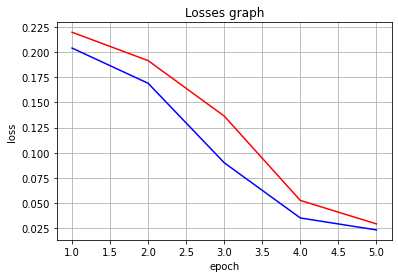

Epoch [1/10], Loss: 0.017642, accuracy: 55.247
Epoch [1/10], Loss: 0.011444, accuracy: 65.046
Epoch [1/10], Loss: 0.010123, accuracy: 69.599
Epoch [1/10], Loss: 0.010519, accuracy: 66.281
Epoch [1/10], Loss: 0.009943, accuracy: 70.602
Epoch [1/10], Loss: 0.012524, accuracy: 63.194
Epoch [1/10], Loss: 0.019521, accuracy: 43.364
Epoch [1/10], Loss: 0.016893, accuracy: 54.707
Epoch [1/10], Loss: 0.021970, accuracy: 39.120
Epoch [1/10], Loss: 0.012022, accuracy: 67.052
Epoch [1/10], Loss: 0.022100, accuracy: 32.562
Epoch [1/10], Loss: 0.019652, accuracy: 41.281
Epoch [1/10], Loss: 0.012858, accuracy: 63.426
Epoch [1/10], Loss: 0.011651, accuracy: 63.349
Epoch [1/10], Loss: 0.012509, accuracy: 62.809
Epoch [1/10], Loss: 0.013197, accuracy: 56.636
Epoch [1/10], Loss: 0.019724, accuracy: 43.750
Epoch [1/10], Loss: 0.017220, accuracy: 55.015
Epoch [1/10], Loss: 0.023172, accuracy: 40.046
Epoch [1/10], Loss: 0.019659, accuracy: 43.287
Epoch [1/10], Loss: 0.013167, accuracy: 62.963
Epoch [1/10],

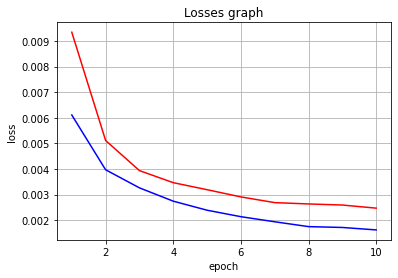

Epoch [1/15], Loss: 0.000662, accuracy: 96.142
Epoch [1/15], Loss: 0.000752, accuracy: 95.062
Epoch [1/15], Loss: 0.000850, accuracy: 94.213
Epoch [1/15], Loss: 0.000456, accuracy: 97.608
Epoch [1/15], Loss: 0.000563, accuracy: 97.299
Epoch [1/15], Loss: 0.000732, accuracy: 95.216
Epoch [1/15], Loss: 0.000607, accuracy: 96.914
Epoch [1/15], Loss: 0.000868, accuracy: 94.907
Epoch [1/15], Loss: 0.000453, accuracy: 97.377
Epoch [1/15], Loss: 0.000943, accuracy: 93.981
Epoch [1/15], Loss: 0.001076, accuracy: 93.827
Epoch [1/15], Loss: 0.001090, accuracy: 93.364
Epoch [1/15], Loss: 0.000829, accuracy: 94.444
Epoch [1/15], Loss: 0.000788, accuracy: 95.139
Epoch [1/15], Loss: 0.001031, accuracy: 94.136
Epoch [1/15], Loss: 0.001020, accuracy: 94.059
Epoch [1/15], Loss: 0.000884, accuracy: 94.907
Epoch [1/15], Loss: 0.000572, accuracy: 97.068
Epoch [1/15], Loss: 0.000723, accuracy: 95.293
Epoch [1/15], Loss: 0.000566, accuracy: 97.377
Epoch [1/15], Loss: 0.001055, accuracy: 93.596
Epoch [1/15],

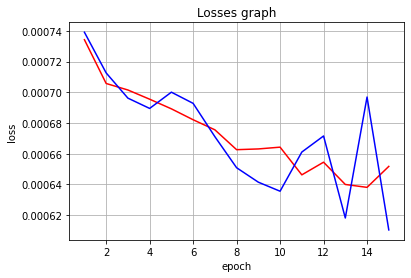

In [20]:
blur_run()